Sarthak Kapoor - MSc SiSc
(Mat# 416194)

# Introduction

Within the bounds of Project 3 for the course 'Fast Iterative Solvers' given by Prof. Georg May at RWTH Aachen, we have implemented and compared two methods for computing the dominant eigenvalue of real symmetric positive definite matrices (large sparse matrices). 

These methods are Power Iterations and Lanczos method. We started with defining some helper functions, followed by implementing Power Iterations and testing it on NOS6 matrix taken from Matrix-market. We then implemented Lanczos method and tested it on S3RMT3M3 matrix taken from Matrix-market. For comparison, we test Power Iterations for S3RMT3M3 matrix as well. In the end, we have compared the performance of the two methods.


# Library imports, helper functions and matrices loading

Following libraries have been imported:
1.  `matplotlib.pyplot` - for generating plots
2.  `time` - for calculating the runtimes

Following helper functions have been used: 
1.  `add(a,b)` - adds two vectors `a` and `b`
2.  `constMultiply(a,b)` - multiplies vector `a` with constant `b`
3.  `dotProduct(a,b)` - calculates dot product of vectors `a` and `b`
4.  `norm(a)` - calculates norm of vector `a`
5.  `normalize(a)` - calculates normalized vector for vector `a`
6.  `transpose(a)` - calculates the transpose of the vector `a`
7.  `symmetric(a)` - returns bool `True` if `a` is symmetric, otherwise `False`
8.  `readmtxCRS(filename,sym)` - reads .mtx file and returns the matrix in CRS format
9.  `denseToCRS(a)` - converts matrix `a` in dense format to CRS format
10.  `matVecProductCRS(A,x)` - multiplies matrix `A` (in CRS format) with vector `x`


In [1]:
import matplotlib.pyplot as plt
import time

def add(a,b):
    x = [[0 for i in range(len(a[0]))]]
    for i in range(len(a[0])):
        x[0][i]=a[0][i]+b[0][i]
    return x

def constMultiply(a,b):
    return [[i*b for i in a[0]]]

def dotProduct(a,b):
    dot=0
    for i in range(len(a[0])):
        dot = dot + a[0][i]*b[0][i]
    return dot

def norm(a):
    return dotProduct(a,a)**0.5

def normalize(a):
    return constMultiply(a,1/norm(a))

def transpose(a):
    aT= [[0 for i in range(len(a))] for j in range(len(a[0]))]
    
    # calculating the hermitian transpose
    for i in range(len(a[0])):
        for j in range(len(a)):
            aT[i][j]=a[j][i]
    return aT

def symmetric(a):
    aT= transpose(a)
    # comparing the elements and returning 'not symmetric' at the first unequal corresponding elements
    for i in range(len(a)):
        for j in range(len(a[0])):
            if (aT[i][j] != a[i][j]):
                return False
    # return 'symmetric' if all the corresponding elements are equal
    return True

def readmtxCRS(filename, sym=True):
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('%'):
                continue                           # ignoring the comments in file
            meta = [int(i) for i in line.split()]  # storing the meta data
            break
        
        coo = []
        
        for line in f:
            coo.append([float(i) for i in line.split()])
            coo[-1][0] = int(coo[-1][0])
            coo[-1][1] = int(coo[-1][1])
    
    coo.sort()              # to sort the list with respect to rows   
    
    index=0
    i_old = 1
    I=[index];              # first element of I is 0
    J=[]; V=[] 
    
    if sym:
        for row in coo:
            if row[0]<row[1]:
                continue
            if row[0]!=i_old:
                I.append(index)
                i_old = row[0]
            index+=1
            J.append(row[1]-1)
            V.append(row[2])
        I.append(index)
    
    else:
        for row in coo:
            if row[0]!=i_old:
                I.append(index)
                i_old = row[0]
            index+=1
            J.append(row[1]-1)
            V.append(row[2])
        I.append(index)
            
    A=[I, J, V, symmetric]       
    
    return A
    
def denseToCRS(a):
    
    # denseToCRS(a) takes input of dense matrix and returns A in CRS format
    # A contains 3 lists and 1 bool: 
    # lists containing the array I, array J and array V
    # bool containing True if matrix is symmetric, otherwise False
    
    index=0
    I=[index];                          # first element of I is 0
    J=[]; V=[] 
    
    sym=symmetric(a)                    # determine whether 'a' is symmetric or not  
    
    if (sym):
    #    print("-> Symmetric", flush=True)
        for i in range(len(a)):
            for j in range(i+1):        # for symmetric case, going over only the lower triangle
                val=a[i][j]
                if (val!=0):
                    index=index+1       # counting number of non-zero elements per row
                    J.append(j)         # appending J with the column number for the respective non-zero element
                    V.append(val)       # appending V with the value of respective non-zero element
            I.append(index)             # appending I which number of non-zero elements per row
    else:
    #    print("-> Non-symmetric", flush=True)
        for i in range(len(a)):
            for j in range(len(a[0])):  # going over all the matrix elements
                val=a[i][j]
                if (val!=0):
                    index=index+1
                    J.append(j)
                    V.append(val)
            I.append(index)
            
    A=[I, J, V, sym]        
    
    return A

def matVecProductCRS(A,x):
    ''' A is in CRS format with arguments [I,J,V,sym] and x is a vector
        we compute the matrix vector product with CRS algorithm for non-symmetric
        and using CRS-CCS (compressed column storage) algorithm for symmetric
    '''
    # taking I,J,V,sym values from A matrix
    I=A[0]
    J=A[1]
    V=A[2]
    sym=A[3]
    y=[]
    
    if len(A[0])!=len(x[0])+1:
        print("matVecProductCRS: Error in dimensions.")
        return 0;
    
    # non-symmetric case
    if sym==False:                        
        for i in range(len(I)-1):         # len(I)-1 keeps the iter i2 within bounds
            i1=I[i]
            i2=I[i+1]
            
            # calculating dot product of given matrix row with vector x
            # V[i1:i2] slices the non-zero elements values present in the i-th row
            # J[i1:i2] slices the column indices for those elements
            # x[j] gives vector elements that will multiply with non-zero matrix elements from i-th row
            dot=dotProduct([V[i1:i2]],[[x[0][j] for j in J[i1:i2]]])
            
            # appending the i-th element of solution vector
            y.append(dot)
    
    # symmetric case
    else:   
        
        # processing symmetric matrices in two parts
        # lower triangle (ignoring diagonal) is computed over using CRS-matVecProduct algorithm over stored CRS entries
        # upper triangle (with diagonal) is computed over using CCS-matVecProduct algorithm over stored CRS entries
        
        for i in range(len(I)-1):
            i1=I[i]
            i2=I[i+1]-1                     # i1:i2-1  will skip diagnal entries from the matrix
            
            dot=dotProduct([V[i1:i2]],[[x[0][j] for j in J[i1:i2]]])     
            y.append(dot)

        for i in range(len(I)-1):
            i1=I[i]
            i2=I[i+1]
           
            v=V[i1:i2]
            
            i3=0
            for j in J[i1:i2]:
                y[j] = y[j] + v[i3]*x[0][i]    # CCS-matVecProduct algorithm
                i3=i3+1

    return [y]

## Loading Matrices

We have used two sparse matrices from Matrix-Market (https://math.nist.gov/MatrixMarket/) - NOS6 and S3RMT3M3. Both of these are real symmetric positive definite, therefore will have only real eigenvalues.

In [2]:
A1 = readmtxCRS('nos6.mtx', True)
A2 = readmtxCRS('s3rmt3m3.mtx', True)

# Power iteration

Power iteration is used to approximate the dominant eigenvalue (maximum) and eigenvector of a matrix. We have implemented the same using the function `powerIteration(A,q0,tol)` where `A` is the given matrix (symmetric positive definite in our study), `q0` is the initial guess for the dominant eigenvector and `tol` is the tolerence that gives the convergence criterion to stop the iterations. It is important that the initial guess is not orthogonal to the actual dominant eigenvector. 

In [3]:
def powerIteration(A,q0,tol):
    
    eig = [23,21]
    abs_diff = []
    t = []
    
    start = time.time()                                  # time starts 
    
    q = normalize(q0)
    z1 = matVecProductCRS(A,q)
    while True:
        q = normalize(z1)
        z1 = matVecProductCRS(A,q)
        eig[1] = dotProduct(q,z1)                       # since the matrices we are working with are spd, no need for Hermitian transpose
        
        abs_diff.append(abs(eig[1]-eig[0]))
        eig[0] = eig[1]
        
        t.append(time.time()-start)                     # split time
        
        if abs_diff[-1] < tol:
            break
    
    return eig[0], abs_diff[1:], t[1:]

## Pure Power Iteration for NOS6

The initial guess is taken as $\frac{1}{\sqrt{n}} (1,1,...,1)^T$, where $n=675$ is the length of the square matrix $A$ (NOS6). The cutoff for absolute difference between two successive eigenvalue approximation (error) is taken to be $10^{-8}$. For convergence visualization, this error $|\lambda^{k}-\lambda^{k-1}|$ versus iteration and runtime have been plotted.

Total iterations = 769
Total time (s) = 3.35430908203125
Approximation for maximum eigenvalue = 7.650603e+06


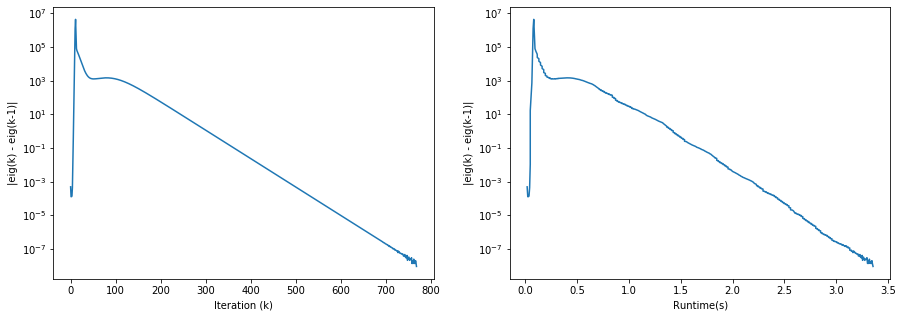

In [4]:
x0 = normalize([[1 for i in range(675)]])
eig,abs_diff,t = powerIteration(A1,x0,1e-8)

print("Total iterations =", len(abs_diff))
print("Total time (s) =", t[-1])
print("Approximation for maximum eigenvalue =", '{:e}'.format(eig))

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.semilogy(abs_diff)
ax.set_xlabel('Iteration (k)')
ax.set_ylabel('|eig(k) - eig(k-1)|')

ax = fig.add_subplot(122)
ax.semilogy(t,abs_diff)
ax.set_xlabel('Runtime(s)')
ax.set_ylabel('|eig(k) - eig(k-1)|')
plt.show()

## Pure Power Iteration for S3RMT3M3

The initial guess is taken as $\frac{1}{\sqrt{n}} (1,1,...,1)^T$, where $n=5357$ is the length of the square matrix $A$ (S3RMT3M3). The cutoff for absolute difference between two successive eigenvalue approximation (error) is taken to be $10^{-8}$. For convergence visualization, this error $|\lambda^{k}-\lambda^{k-1}|$ versus iteration and runtime have been plotted. The maximum eigenvalue quoted on the Matrix Market website is $9.5986080894852857E+03$, which is equal to our value upto eighth decimals. 

Total iterations = 2144
Total time (s) = 153.15770506858826
Approximation for maximum eigenvalue = 9.5986080879639758e+03


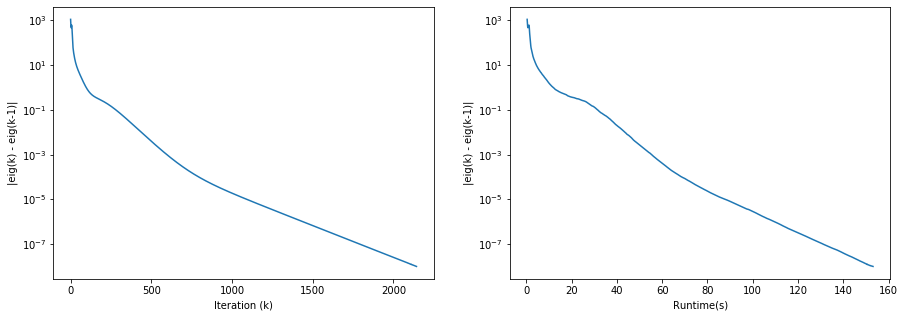

In [5]:
x0 = normalize([[1 for i in range(5357)]])
eig,abs_diff,t = powerIteration(A2,x0,1e-8)

print("Total iterations =", len(abs_diff))
print("Total time (s) =", t[-1])
print("Approximation for maximum eigenvalue =", '{:.16e}'.format(eig))

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.semilogy(abs_diff)
ax.set_xlabel('Iteration (k)')
ax.set_ylabel('|eig(k) - eig(k-1)|')

ax = fig.add_subplot(122)
ax.semilogy(t,abs_diff)
ax.set_xlabel('Runtime(s)')
ax.set_ylabel('|eig(k) - eig(k-1)|')
plt.show()

# Lanczos Method

Lanczos algorithm computes the $(m \times m)$ upper Hessenberg matrix $(H_m)$ of the given symmetric $(n \times n)$ matrix $(A)$, where $m<<n$. $H_m$ can be taken as a 'projection' of $A$ in a lower dimension space. We can then use power iteration to approximate the dominant eigenvalue of $H_m$, which gives us a close estimate of the dominant eigenvalue of $A$, but at a significantly lower computational cost than direct application of power iteration on $A$.

We have defined the Lanczos method in function `Lanczos(A,v,m,tol)` where `A` is the given square matrix, `v` is the initial guess for the dominant eigenvector, `m` specifies the dimensions of Hessenberg matrix and `tol` gives the convergence criterion. The algorithm computes $H_m$ and then runs power iteration on it.

In [6]:
def Lanczos(A,v,m,tol):
    a = []
    b = [0]
    v1 = v[:]
    
    start = time.time()
    for j in range(m):
        w = add(matVecProductCRS(A,v1),constMultiply(v,-b[-1]))
        a.append(dotProduct(w,v1))
        w = add(w,constMultiply(v1,-a[-1]))
        b.append(norm(w))
        v = v1[:]
        v1 = normalize(constMultiply(w,b[-1]))                         
    
    Hm = [[0 for i in range(m)] for i in range(m)]
    for i in range(m):
        Hm[i][i] = a[i]
    for i in range(1,m):
        Hm[i-1][i] = Hm[i][i-1] = b[i]
    
    Hm = denseToCRS(Hm)
    x0 = normalize([[1 for i in range(m)]])
    
    eig,_,_ = powerIteration(Hm,x0,tol)
    end = time.time()
    
    return eig, end-start
    

## Lanczos Method for S3RMT3M3

We run the Lanczos Method on s3rmt3m3.mtx matrix with $m=30,50,75,100$ and $tol=10^{-2},10^{-4},10^{-6},10^{-10}$ respectively. Then, we plot the error $|\lambda^k - \lambda_{max}|$ with respect to the known value for dominant eigenvalue $(\lambda_{max}=9598.6080894852857)$ against runtime. 

In [7]:
eig_arr=[]
time_arr=[]
x0 = normalize([[1 for i in range(5357)]])

eig,t = Lanczos(A2,x0,30,1e-2)
eig_arr.append(eig)
time_arr.append(t)
print("Using m=30 and tol=1e-2, approximation for maximum eigenvalue =", eig)

eig,t = Lanczos(A2,x0,50,1e-4)
eig_arr.append(eig)
time_arr.append(t)
print("Using m=50 and tol=1e-4, approximation for maximum eigenvalue =", eig)

eig,t = Lanczos(A2,x0,75,1e-6)
eig_arr.append(eig)
time_arr.append(t)
print("Using m=75 and tol=1e-6, approximation for maximum eigenvalue =", eig)

eig,t = Lanczos(A2,x0,100,1e-10)
eig_arr.append(eig)
time_arr.append(t)
print("Using m=100 and tol=1e-10, approximation for maximum eigenvalue =", eig)

Using m=30 and tol=1e-2, approximation for maximum eigenvalue = 9582.919745743697
Using m=50 and tol=1e-4, approximation for maximum eigenvalue = 9598.531221380197
Using m=75 and tol=1e-6, approximation for maximum eigenvalue = 9598.60793744962
Using m=100 and tol=1e-10, approximation for maximum eigenvalue = 9598.608089468826


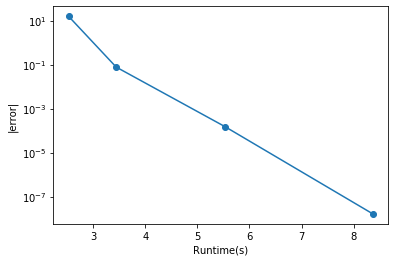

Time taken for each run = [2.520904541015625, 3.437260866165161, 5.528246641159058, 8.372457504272461]


In [8]:
plt.semilogy(time_arr, [abs(i-9598.6080894852857) for i in eig_arr],'o-')
plt.xlabel("Runtime(s)")
plt.ylabel("|error|")
plt.show()
print('Time taken for each run =',time_arr)

#### Fitting a line for estimate of rate of convergence through slope

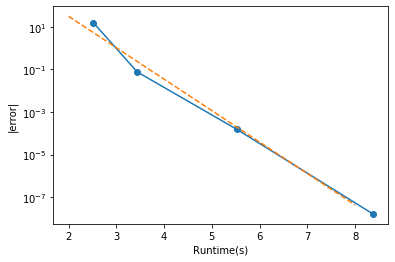

y = -1.4773841722847758 x + 4.4547197661976385


In [9]:
import numpy as np 
m,b = np.polyfit(time_arr,np.log10([abs(i-9598.6080894852857) for i in eig_arr]),1)

plt.semilogy(time_arr, [abs(i-9598.6080894852857) for i in eig_arr],'o-')
plt.xlabel("Runtime(s)")
plt.ylabel("|error|")
x = np.linspace(2,8,100)
plt.plot(x,10**(m*x+b),'--')
plt.show()

print("y =",m,"x +",b)

## Convergence comparison with Power Iteration

We have additionally plotted the error versus runtime plot to compare the convergence behavior of Power Iteration and Lanczos method directly. For the same, we have editted the function `powerIteration` to generate a different output.   

Total iterations = 2145
Total time (s) = 142.00094890594482
Approximation for maximum eigenvalue = 9.5986080879639758e+03


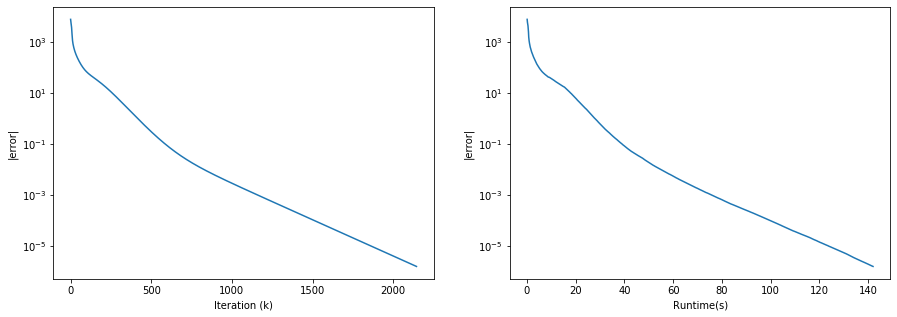

In [10]:
def powerIteration(A,q0,tol):
    
    eig = [23,21]
    error = []
    t = []
    
    start = time.time()                                  # time starts 
    
    q = normalize(q0)
    z1 = matVecProductCRS(A,q)
    while True:
        q = normalize(z1)
        z1 = matVecProductCRS(A,q)
        eig[1] = dotProduct(q,z1)                       # since the matrices we are working with are spd, no need for Hermitian transpose
        
        error.append(abs(eig[1]-9598.6080894852857))
        
        t.append(time.time()-start)                     # split time
        
        if eig[1]-eig[0] < tol:
            break
        eig[0] = eig[1]
    
    return eig[1], error, t

x0 = normalize([[1 for i in range(5357)]])
eig,error,t = powerIteration(A2,x0,1e-8)

print("Total iterations =", len(error))
print("Total time (s) =", t[-1])
print("Approximation for maximum eigenvalue =", '{:.16e}'.format(eig))

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.semilogy(error)
ax.set_xlabel('Iteration (k)')
ax.set_ylabel('|error|')

ax = fig.add_subplot(122)
ax.semilogy(t,error)
ax.set_xlabel('Runtime(s)')
ax.set_ylabel('|error|')
plt.show()

#### Fitting a line for estimate of rate of convergence through slope

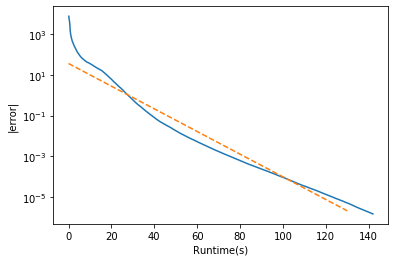

y = -0.055514705155503496 x + 1.55285497608712


In [11]:
m,b = np.polyfit(t,np.log10(error),1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(t,error)
ax.set_xlabel('Runtime(s)')
ax.set_ylabel('|error|')
x = np.linspace(0,130,200)
plt.plot(x,10**(m*x+b),'--')
plt.show()
print("y =",m,"x +",b)

# Observation and Conclusion

Both Power Iteration and Lanczos method find the dominant eigenvalue of a large sparse matrix S3RMT3M3 upto specified accuracy. However, Lanczos method is significantly faster than Power Iteration. With `m=100`, Lanczos method found the dominant eigenvalue correct upto 10 decimals in 7-9 seconds on average. On the other hand, pure Power Iteration took 140-155 seconds on average to compute the dominant eigenvalue correct upto 8 decimals. 

The convergence rate remains almost constant for Lanczos method, whereas it drops and becomes constant with time for Power Iteration. Moreover, the estimate for average convergence rate of Lanczos is more (steeper fitted slope of -1.477) than that of pure Power Iteration (fitted slope of -0.0555).   